 # Chapter 7: Face Image Processing

## Problems

## 1. Face morphing with dlib, scipy.spatial and opencv-python

In [6]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

In [7]:
%matplotlib inline
#!pip install dlib
from scipy.spatial import Delaunay
from skimage.io import imread
import scipy.misc
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Find 68 face landmarks using dlib
def extract_landmarks(img, add_boundary_points=True, predictor_path = 'models/shape_predictor_68_face_landmarks.dat'):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  try:
    #points = stasm.search_single(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    dets = detector(img, 1)
    points = np.zeros((68, 2))
    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
        for i in range(68):
            points[i, 0] = shape.part(i).x
            points[i, 1] = shape.part(i).y
  except Exception as e:
    print('Failed finding face points: ', e)
    return []
  points = points.astype(np.int32)
  return points

In [7]:
src_path = 'images/Img_07_02.jpg'
dst_path = 'images/Img_07_03.jpg'

src_img = imread(src_path)
dst_img = imread(dst_path)

src_points = extract_landmarks(src_img)
dst_points = extract_landmarks(dst_img)

Detection 0: Left: -31 Top: 43 Right: 216 Bottom: 266
Detection 0: Left: 35 Top: 98 Right: 221 Bottom: 284


In [20]:
def weighted_average_points(start_points, end_points, percent=0.5):
  if percent <= 0:
    return end_points
  elif percent >= 1:
    return start_points
  else:
    return np.asarray(start_points*percent + end_points*(1-percent), np.int32)

In [21]:
def bilinear_interpolate(img, coords):
  int_coords = np.int32(coords)
  x0, y0 = int_coords
  dx, dy = coords - int_coords

  # 4 Neighour pixels
  q11 = img[y0, x0]
  q21 = img[y0, x0+1]
  q12 = img[y0+1, x0]
  q22 = img[y0+1, x0+1]

  btm = q21.T * dx + q11.T * (1 - dx)
  top = q22.T * dx + q12.T * (1 - dx)
  inter_pixel = top * dy + btm * (1 - dy)

  return inter_pixel.T

In [22]:
def get_grid_coordinates(points):
  xmin = np.min(points[:, 0])
  xmax = np.max(points[:, 0]) + 1
  ymin = np.min(points[:, 1])
  ymax = np.max(points[:, 1]) + 1
  return np.asarray([(x, y) for y in range(ymin, ymax)
                     for x in range(xmin, xmax)], np.uint32)

In [23]:
def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
  roi_coords = get_grid_coordinates(dst_points)
  # indices to vertices. -1 if pixel is not in any triangle
  roi_tri_indices = delaunay.find_simplex(roi_coords)

  for simplex_index in range(len(delaunay.simplices)):
    coords = roi_coords[roi_tri_indices == simplex_index]
    num_coords = len(coords)
    out_coords = np.dot(tri_affines[simplex_index], np.vstack((coords.T, np.ones(num_coords))))
    x, y = coords.T
    result_img[y, x] = bilinear_interpolate(src_img, out_coords)
  return None

In [24]:
def get_triangular_affine_matrices(vertices, src_points, dest_points):
  ones = [1, 1, 1]
  for tri_indices in vertices:
    src_tri = np.vstack((src_points[tri_indices, :].T, ones))
    dst_tri = np.vstack((dest_points[tri_indices, :].T, ones))
    mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
    yield mat

In [25]:
def warp_image(src_img, src_points, dest_points, dest_shape, dtype=np.uint8):
  num_chans = 3
  src_img = src_img[:, :, :3]
  rows, cols = dest_shape[:2]
  result_img = np.zeros((rows, cols, num_chans), dtype)
  delaunay = Delaunay(dest_points)
  tri_affines = np.asarray(list(get_triangular_affine_matrices(delaunay.simplices, src_points, dest_points)))
  process_warp(src_img, result_img, tri_affines, dest_points, delaunay)
  return result_img, delaunay

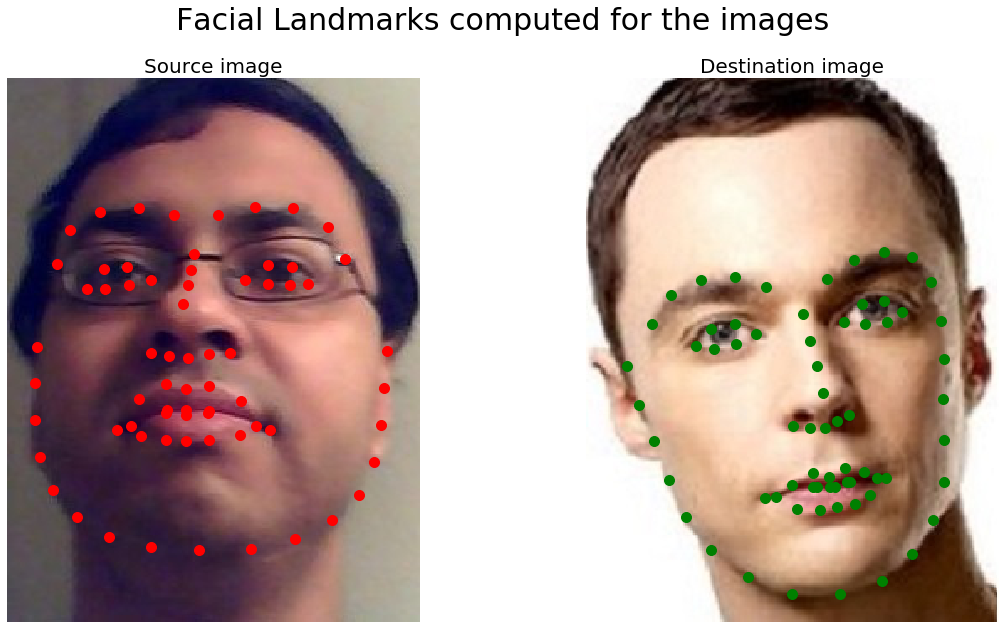

In [26]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(src_img)
for i in range(68):
    plt.plot(src_points[i,0], src_points[i,1], 'r.', markersize=20)
plt.title('Source image', size=20)
plt.axis('off')
plt.subplot(122)
plt.imshow(dst_img)
for i in range(68):
    plt.plot(dst_points[i,0], dst_points[i,1], 'g.', markersize=20)
plt.title('Destination image', size=20)
plt.axis('off')
plt.suptitle('Facial Landmarks computed for the images', size=30)
fig.subplots_adjust(wspace=0.01, left=0.1, right=0.9)
plt.show()

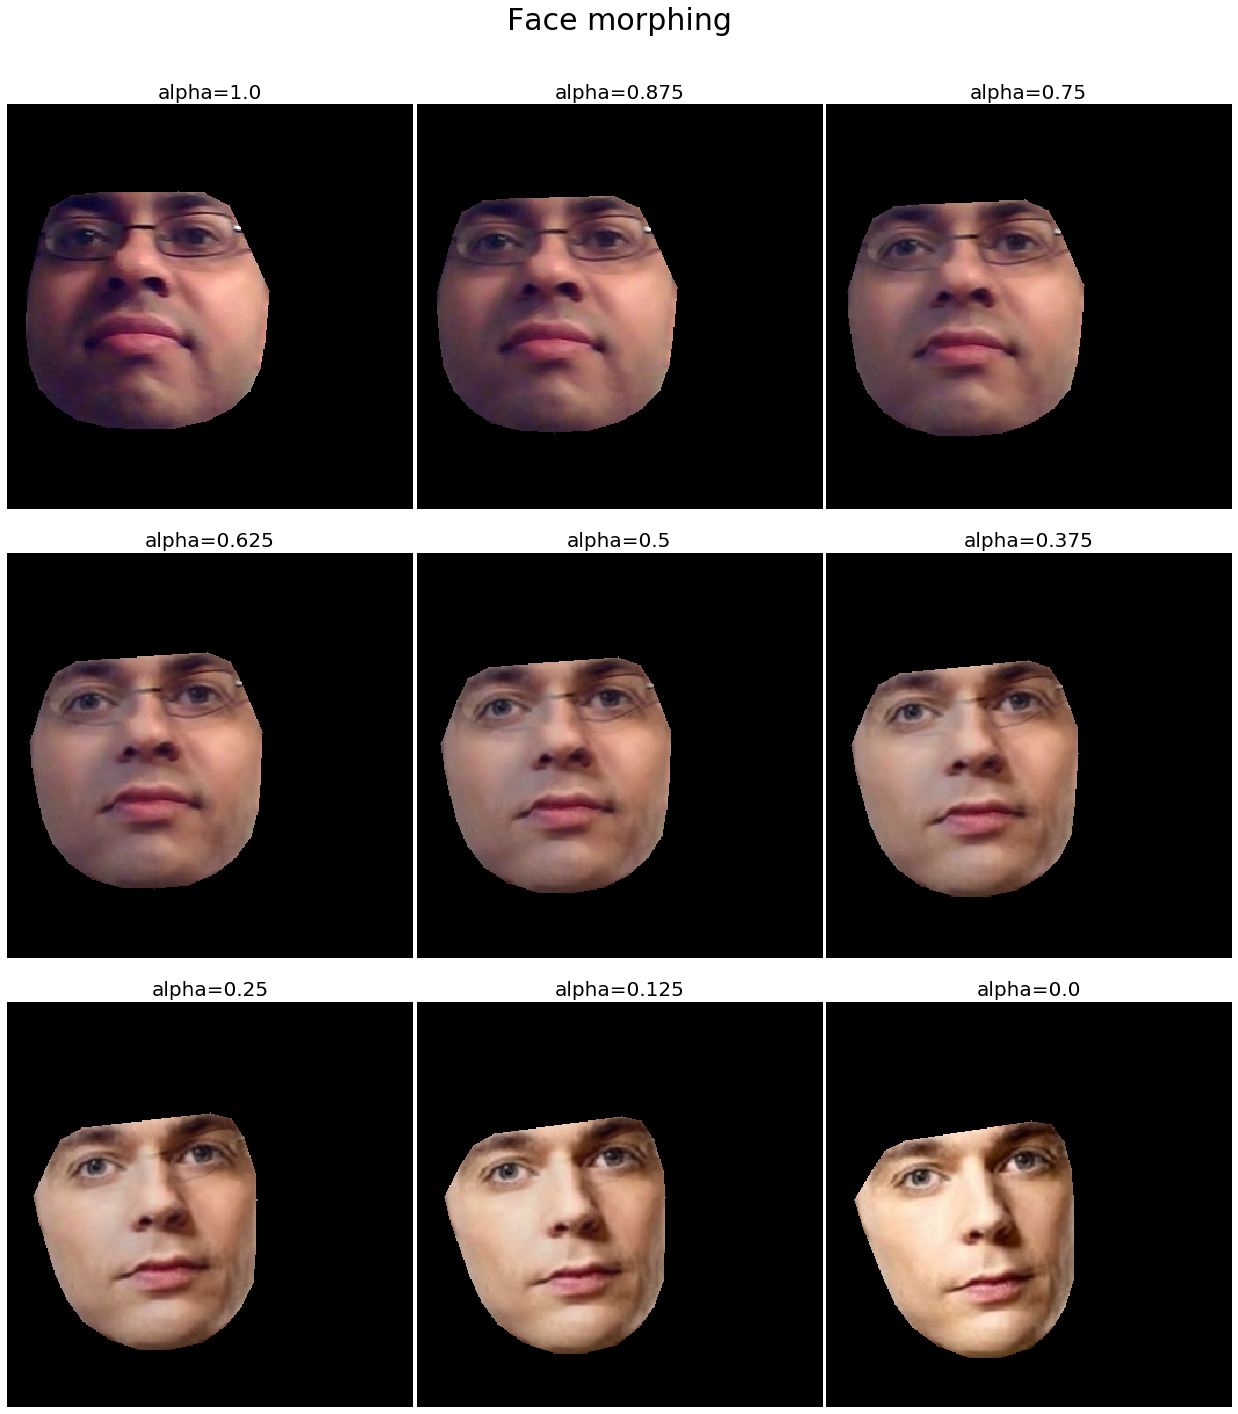

In [33]:
fig = plt.figure(figsize=(20,20))
# Produce morph frames!
i = 1
for percent in np.linspace(1, 0, 9):
    points = weighted_average_points(src_points, dst_points, percent)
    src_face, src_d = warp_image(src_img, src_points, points, (350,350))
    end_face, end_d = warp_image(dst_img, dst_points, points, (350,350))
    average_face = weighted_average_points(src_face, end_face, percent)
    plt.subplot(3, 3, i)
    plt.imshow(average_face)
    plt.title('alpha=' + str(percent), size=20)
    plt.axis('off')
    i += 1
plt.suptitle('Face morphing', size=30)
fig.subplots_adjust(top=0.92, bottom=0, left=0.075, right=0.925, wspace=0.01, hspace=0.05)
plt.show()

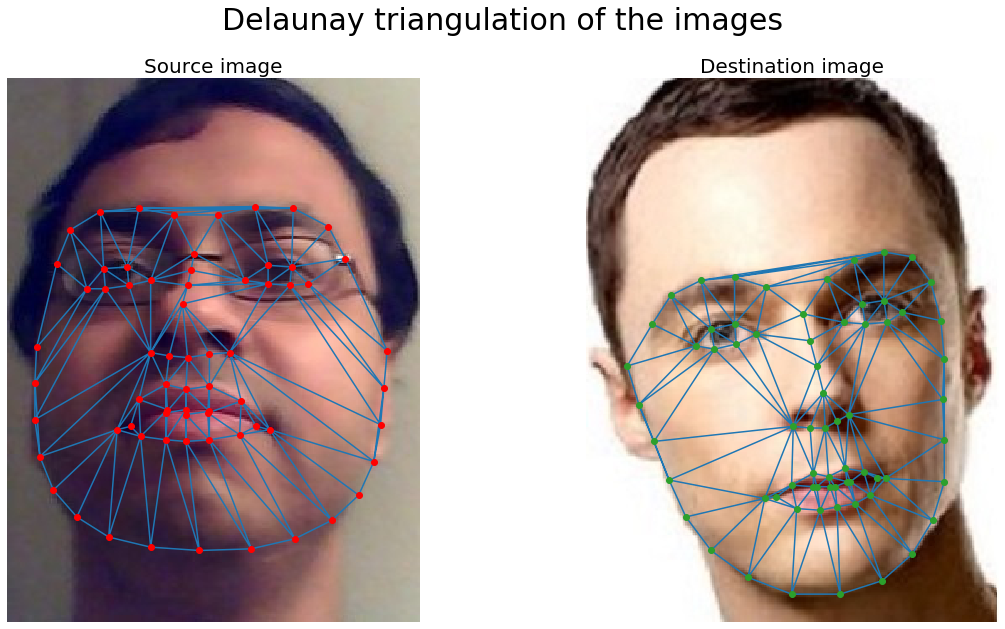

In [34]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(src_img)
plt.triplot(src_points[:,0], src_points[:,1], src_d.simplices.copy())
plt.plot(src_points[:,0], src_points[:,1], 'o', color='red')
plt.title('Source image', size=20)
plt.axis('off')
plt.subplot(122)
plt.imshow(dst_img)
plt.triplot(dst_points[:,0], dst_points[:,1], end_d.simplices.copy())
plt.plot(dst_points[:,0], dst_points[:,1], 'o')
plt.title('Destination image', size=20)
plt.axis('off')
plt.suptitle('Delaunay triangulation of the images', size=30)
fig.subplots_adjust(wspace=0.01, left=0.1, right=0.9)
plt.show()

## 2. Facial Landmark Detection with Deep Learning Models

### 2.1 Facial Landmark Detection with Keras

In [37]:
#!pip install tensorflow==1.14
#!pip install keras==2.2.4
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
#print(tensorflow.__version__)
# 1.14.0
from keras.models import load_model
from keras import backend as K
from keras.utils.generic_utils import custom_object_scope
import cv2
from skimage import img_as_float

In [38]:
huber_delta = 0.5

def smoothL1(y_true, y_pred):
    x = K.abs(y_true - y_pred)
    x = K.switch(x < huber_delta, 0.5 * x ** 2, huber_delta * (x - 0.5 * huber_delta))
    return  K.sum(x)

In [54]:
weights = np.empty((136,)) 
# Outer: Brows: Nose: Eyes: Mouth (0.5 : 1 : 2 : 3 : 1)
weights[0:33] = 0.5
weights[33:53] = 1
weights[53:71] = 2
weights[71:95] = 3
weights[95:] = 1

def mask_weights(y_true, y_pred):
    x = K.abs(y_true - y_pred) * weights
    return K.sum(x)

In [49]:
def relu6(x):
    return K.relu(x, max_value=6)

In [56]:
model = "models/Mobilenet_v1.hdf5"
image_color = cv2.resize(cv2.imread('images/Img_07_02.jpg'), (64, 64))
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
w, h = image_gray.shape

with custom_object_scope({'smoothL1': smoothL1, 'relu6': relu6, 
    'mask_weights': mask_weights, 'tf': tf}):
    sess = load_model(model)
    predictions = sess.predict_on_batch(np.reshape(image_gray, (1, w, h, 1)))
#predictions = sess.predict_on_batch(np.reshape(img_as_float(image_gray), (1, w, h, 1)))

# Convert predictions to landmarks.
marks = np.array(predictions).flatten()
marks = np.reshape(marks, (-1, 2))
print(marks.shape)

(68, 2)


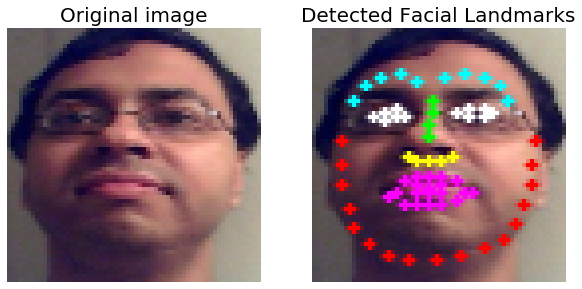

In [57]:
image = image_color.copy()
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original image', size=20)
for mark in marks[:17]:
    cv2.circle(image, (int(w*mark[0]), int(h*mark[1])), 1, (0,0,255), -1, cv2.LINE_AA)
for mark in marks[17:27]:
    cv2.circle(image, (int(w*mark[0]), int(h*mark[1])), 1, (255,255,0), -1, cv2.LINE_AA)
for mark in marks[27:31]:
    cv2.circle(image, (int(w*mark[0]), int(h*mark[1])), 1, (0,255,0), -1, cv2.LINE_AA)
for mark in marks[31:36]:
    cv2.circle(image, (int(w*mark[0]), int(h*mark[1])), 1, (0,255,255), -1, cv2.LINE_AA)
for mark in marks[36:48]:
    cv2.circle(image, (int(w*mark[0]), int(h*mark[1])), 1, (255,255,255), -1, cv2.LINE_AA)
for mark in marks[48:]:
    cv2.circle(image, (int(w*mark[0]), int(h*mark[1])), 1, (255,0,255), -1, cv2.LINE_AA)

plt.subplot(122), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Detected Facial Landmarks', size=20)
plt.show()

### 2.2 Facial Landmark Detection with MTCNN

In [8]:
#!pip install mtcnn
#!pip install tensorflow==1.14
#!pip install keras==2.2.4
import tensorflow
#print(tensorflow.__version__)
# 1.14.0
import skimage
#print(skimage.__version__)
# 0.17.2
from mtcnn import MTCNN
import cv2
from skimage.draw import rectangle_perimeter
import numpy as np
import matplotlib.pylab as plt

In [9]:
img = cv2.cvtColor(cv2.imread("images/Img_07_02.jpg"), cv2.COLOR_BGR2RGB)
detector = MTCNN()
res = detector.detect_faces(img)
print(res)

[{'box': [12, 12, 214, 275], 'confidence': 1.0, 'keypoints': {'left_eye': (60, 110), 'right_eye': (161, 112), 'nose': (105, 137), 'mouth_left': (65, 204), 'mouth_right': (155, 208)}}]


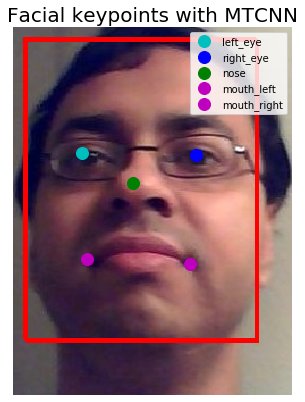

In [10]:
plt.figure(figsize=(5,8))
box = res[0]['box']
rr, cc = rectangle_perimeter(box[0:2][::-1], end=box[2:4][::-1], shape=img.shape)
for k in range(-2,2):
    img[rr+k, cc+k] = np.array([255,0,0])
kp = res[0]['keypoints']
plt.plot(kp['left_eye'][0], kp['left_eye'][1], 'co', markersize=12, label='left_eye')
plt.plot(kp['right_eye'][0], kp['right_eye'][1], 'bo', markersize=12, label='right_eye')
plt.plot(kp['nose'][0], kp['nose'][1], 'go', markersize=12, label='nose')
plt.plot(kp['mouth_left'][0], kp['mouth_left'][1], 'mo', markersize=12, label='mouth_left')
plt.plot(kp['mouth_right'][0], kp['mouth_right'][1], 'mo', markersize=12, label='mouth_right')
plt.imshow(img)
plt.legend(loc='best')
plt.axis('off')
plt.title('Facial keypoints with MTCNN', size=20)
plt.show()

## 3. Implement Face Swapping

In [13]:
#!pip install imutils
import cv2
import dlib
import numpy as np
import matplotlib.pylab as plt
import imutils

In [14]:
predictor_path = "models/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

feather_amount = 11
color_correction_blur = 0.5

# 68 keypoints indices 0:68
# RIGHT_BROW_POINTS 17:22 # LEFT_BROW_POINTS 22:27 # NOSE_POINTS 27:36
# RIGHT_EYE_POINTS 36:42 # LEFT_EYE_POINTS 42:48 # MOUTH_POINTS 48:68

keypoints = list(range(17,68))
left_eye_points, right_eye_points = list(range(42,48)), list(range(36,42))

In [15]:
def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

In [16]:
def get_landmarks(img):    
    rects = detector(img, 0)
    if len(rects) == 0:
        return -1
    return np.array([[p.x, p.y] for p in predictor(img, rects[0]).parts()])

In [17]:
def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    for group in [keypoints]:
        draw_convex_hull(im, landmarks[group], color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    im = cv2.GaussianBlur(im, (feather_amount, feather_amount), 0) > 0
    im = im * 1.0
    im = cv2.GaussianBlur(im, (feather_amount, feather_amount), 0)
    return im

In [18]:
def correct_colours(im1, im2, landmarks1):
    mean_left = np.mean(landmarks1[left_eye_points], axis=0)
    mean_right = np.mean(landmarks1[right_eye_points], axis=0)
    blur_amount = color_correction_blur * np.linalg.norm(mean_left - mean_right)
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0: # make the blur kernel size odd
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)
    # avoid division errors
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)
    return (im2.astype(np.float64) * im1_blur.astype(np.float64) / im2_blur.astype(np.float64))

In [19]:
def plot_image_landmarks(img, img_landmarks, swap_img, swap_img_landmarks):
    img = img.copy()
    for mark in img_landmarks.tolist():
        cv2.circle(img, (mark[0], mark[1]), 1, (0,0,255), 2, cv2.LINE_AA)
    swap_img = swap_img.copy()
    for mark in swap_img_landmarks.tolist():
        cv2.circle(swap_img, (mark[0], mark[1]), 1, (0,0,255), 2, cv2.LINE_AA)        
    plt.figure(figsize=(15,10))
    plt.subplots_adjust(0,0,1,0.95,0.01,0.01)
    plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off')
    plt.subplot(122), plt.imshow(cv2.cvtColor(swap_img.astype(np.uint8), cv2.COLOR_BGR2RGB)), plt.axis('off')
    plt.suptitle('Facial landmarks computed for the faces to be swapped (with dlib shape-predictor)', size=20)
    plt.show()

In [20]:
def face_swap_filter(img_file, swap_img_file):
    
    img = imutils.resize(cv2.imread(img_file), width=400)
    swap_img = imutils.resize(cv2.imread(swap_img_file), width=400)
    
    img_landmarks = get_landmarks(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    swap_img_landmarks = get_landmarks(cv2.cvtColor(swap_img, cv2.COLOR_BGR2GRAY))
    
    plot_image_landmarks(img, img_landmarks, swap_img, swap_img_landmarks)
    
    Hmat, status = cv2.findHomography(swap_img_landmarks[keypoints], img_landmarks[keypoints])
    
    mask = get_face_mask(swap_img, swap_img_landmarks)
    warped_mask = cv2.warpPerspective(mask, Hmat, (img.shape[1], img.shape[0]))
    combined_mask = np.max([get_face_mask(img, img_landmarks), warped_mask], axis=0)    
    warped_swap = cv2.warpPerspective(swap_img, Hmat, (img.shape[1], img.shape[0]))
    output_img = np.clip(img * (1.0 - combined_mask) + warped_swap * combined_mask, 0, 255)
    warped_corrected_swap = correct_colours(img, warped_swap, img_landmarks)
    output_img_corrected = np.clip(img * (1.0 - combined_mask) + warped_corrected_swap * combined_mask, 0, 255)
    
    return (output_img, output_img_corrected)

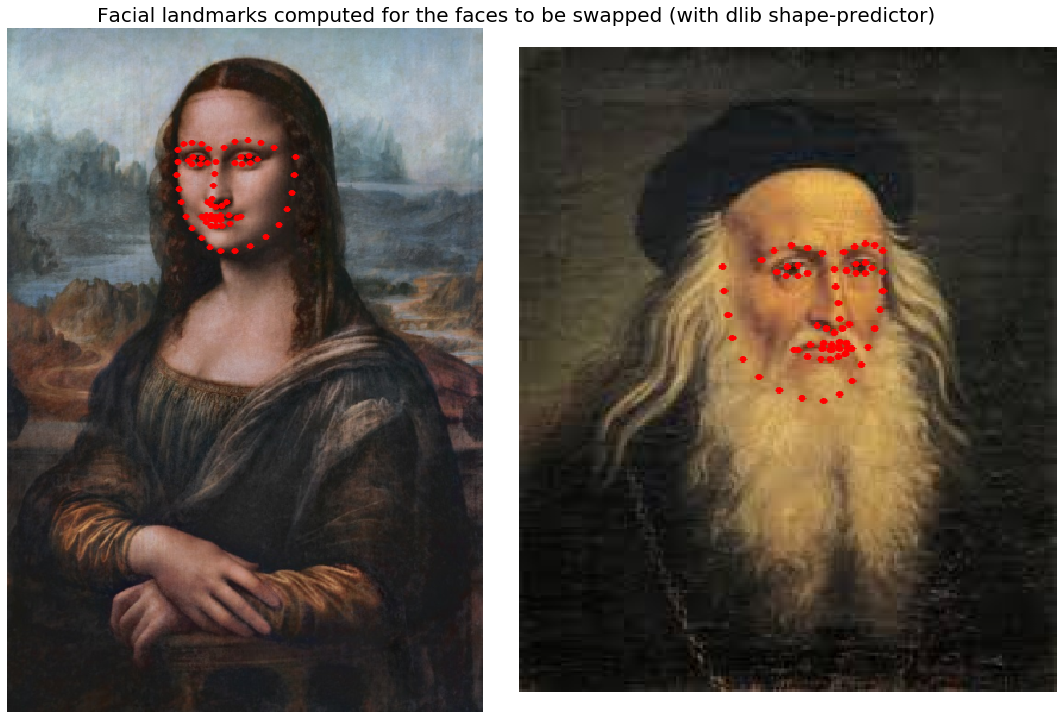

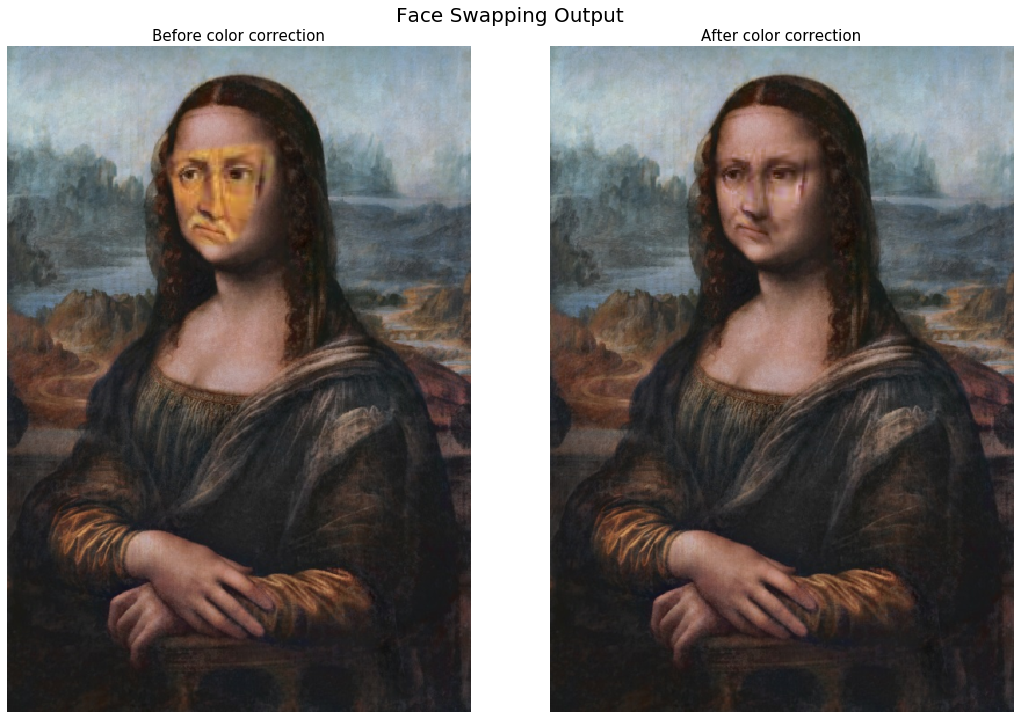

In [21]:
output_img, output_img_corrected = face_swap_filter('images/Img_07_05.jpg', 'images/Img_07_06.jpg')

plt.figure(figsize=(15,10))
plt.subplots_adjust(0,0,1,0.925,0.01,0.01)
plt.subplot(121), plt.imshow(cv2.cvtColor(output_img.astype(np.uint8), cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Before color correction', size=15)
plt.subplot(122), plt.imshow(cv2.cvtColor(output_img_corrected.astype(np.uint8), cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('After color correction', size=15)
plt.suptitle('Face Swapping Output', size=20)
plt.show()

## 4. Implement Face Parsing

In [24]:
import matplotlib.pylab as plt
from mtcnn import MTCNN
from skimage.io import imread
from skimage.draw import rectangle_perimeter
from skimage.util import crop
import tensorflow as tf
import json
from keras.models import model_from_json
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
from matplotlib.colors import ListedColormap

In [31]:
with open("models/BiSeNet_keras.json", 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json, custom_objects={"tf": tf})
model.load_weights('models/BiSeNet_keras.h5')

In [32]:
def normalize_input(x, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        # x should be RGB with range [0, 255]
        return ((x / 255) - mean)  / std

In [33]:
parsing_annos = [
    '0, background', '1, skin', '2, left eyebrow', '3, right eyebrow', 
    '4, left eye', '5, right eye', '6, glasses', '7, left ear', '8, right ear', '9, earings',
    '10, nose', '11, mouth', '12, upper lip', '13, lower lip', 
    '14, neck', '15, neck_l', '16, cloth', '17, hair', '18, hat'
]

# https://matplotlib.org/tutorials/colors/colormap-manipulation.html
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
def show_parsing_with_annos(img, f, ax):
    #get discrete colormap
    cmap = plt.get_cmap('gist_ncar', len(parsing_annos))
    new_colors = cmap(np.linspace(0, 1, len(parsing_annos)))
    new_colors[0, :] = np.array([0, 0, 0, 1.])
    new_cmap = ListedColormap(new_colors)
    # set limits .5 outside true range
    mat = ax.matshow(img, cmap=new_cmap, vmin=-0.5, vmax=18.5)
    #tell the colorbar to tick at integers    
    cbar = f.colorbar(mat, ticks=np.arange(0, len(parsing_annos)))
    cbar.ax.set_yticklabels(parsing_annos)
    ax.axis('off')

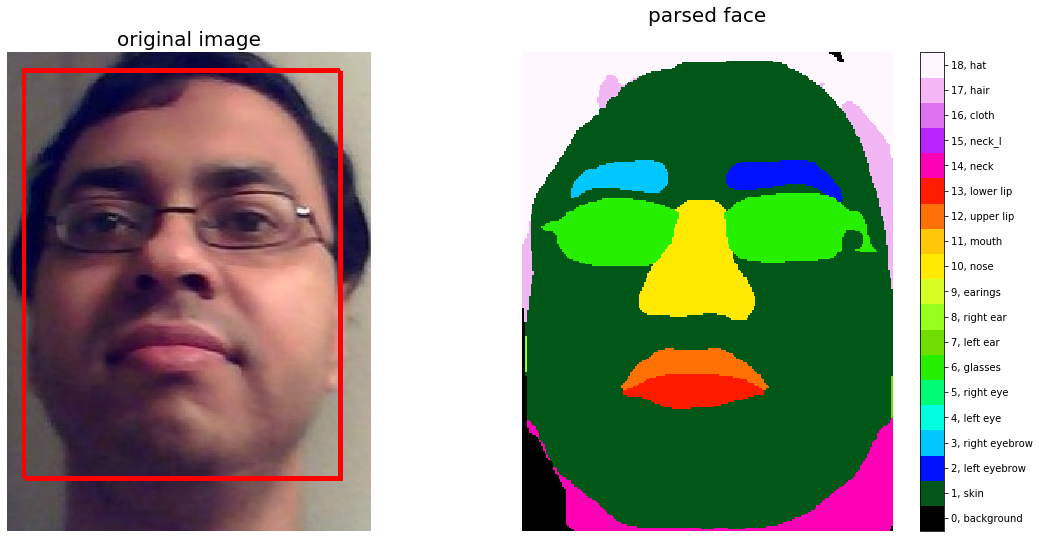

In [35]:
img = imread("images/Img_07_02.jpg")
h, w = img.shape[:2]
detector = MTCNN()
faces = detector.detect_faces(img)
for face in faces:
    bb = face['box']
    face = crop(img,((bb[1],h-(bb[1]+bb[3])),(bb[0],w-(bb[0]+bb[2])),(0,0)))
    rr, cc = rectangle_perimeter((bb[1], bb[0]), extent=(bb[3], bb[2]), shape=img.shape)
    for k in range(-1,2):
        img[rr+k, cc+k,:] = [255,0,0]
    # Preprocess input face for parser networks
    orig_h, orig_w = face.shape[:2]
    inp = 255*resize(face, (512,512))
    inp = normalize_input(inp)
    inp = inp[None, ...]
    # Parser networks forward pass
    # Do NOT use bilinear interp. which adds artifacts to the parsing map
    out = model.predict([inp])[0]
    parsing_map = out.argmax(axis=-1)
    parsing_map = cv2.resize(
        parsing_map.astype(np.uint8), 
        (orig_w, orig_h), 
        interpolation=cv2.INTER_NEAREST)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    plt.subplots_adjust(0,0,1,0.95,0.01,0.01)
    ax1.imshow(img), ax1.axis('off'), ax1.set_title('original image', size=20)
    show_parsing_with_annos(parsing_map, f, ax2), ax2.set_title('parsed face', size=20)
    plt.show()

## 5. Face Recognition with FisherFaces

In [8]:
import cv2
import time, os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [9]:
cascade_path = "models/haarcascade_frontalface_default.xml"

def get_images_and_labels(path):
    faceCascade = cv2.CascadeClassifier(cascade_path)
    image_paths = [os.path.join(path, f) for f in os.listdir(path) if f.startswith('subject') and not f.endswith('glasses.gif')]
    # images will contains face images
    images = np.zeros((15*11, 160*160))
    # labels will contains the label that is assigned to the image
    labels = []
    i = 0
    for image_path in image_paths:
        # Read the image and convert to grayscale
        image_pil = Image.open(image_path).convert('L')
        # Convert the image format into numpy array
        image = np.array(image_pil, 'uint8')
        # Get the label of the image
        nbr = int(os.path.split(image_path)[1].split(".")[0].replace("subject", ""))
        # Detect the face in the image
        faces = faceCascade.detectMultiScale(image)
        # If face is detected, append the face to images and the label to labels
        (x, y, w, h) = faces[0]
        images[i,:] = np.ravel(cv2.resize(image[y: y + h, x: x + w], (160,160)))
        labels.append(nbr)
        i += 1 
    # return the images list and labels list
    return images, labels

images, labels = get_images_and_labels('images/yalefaces')

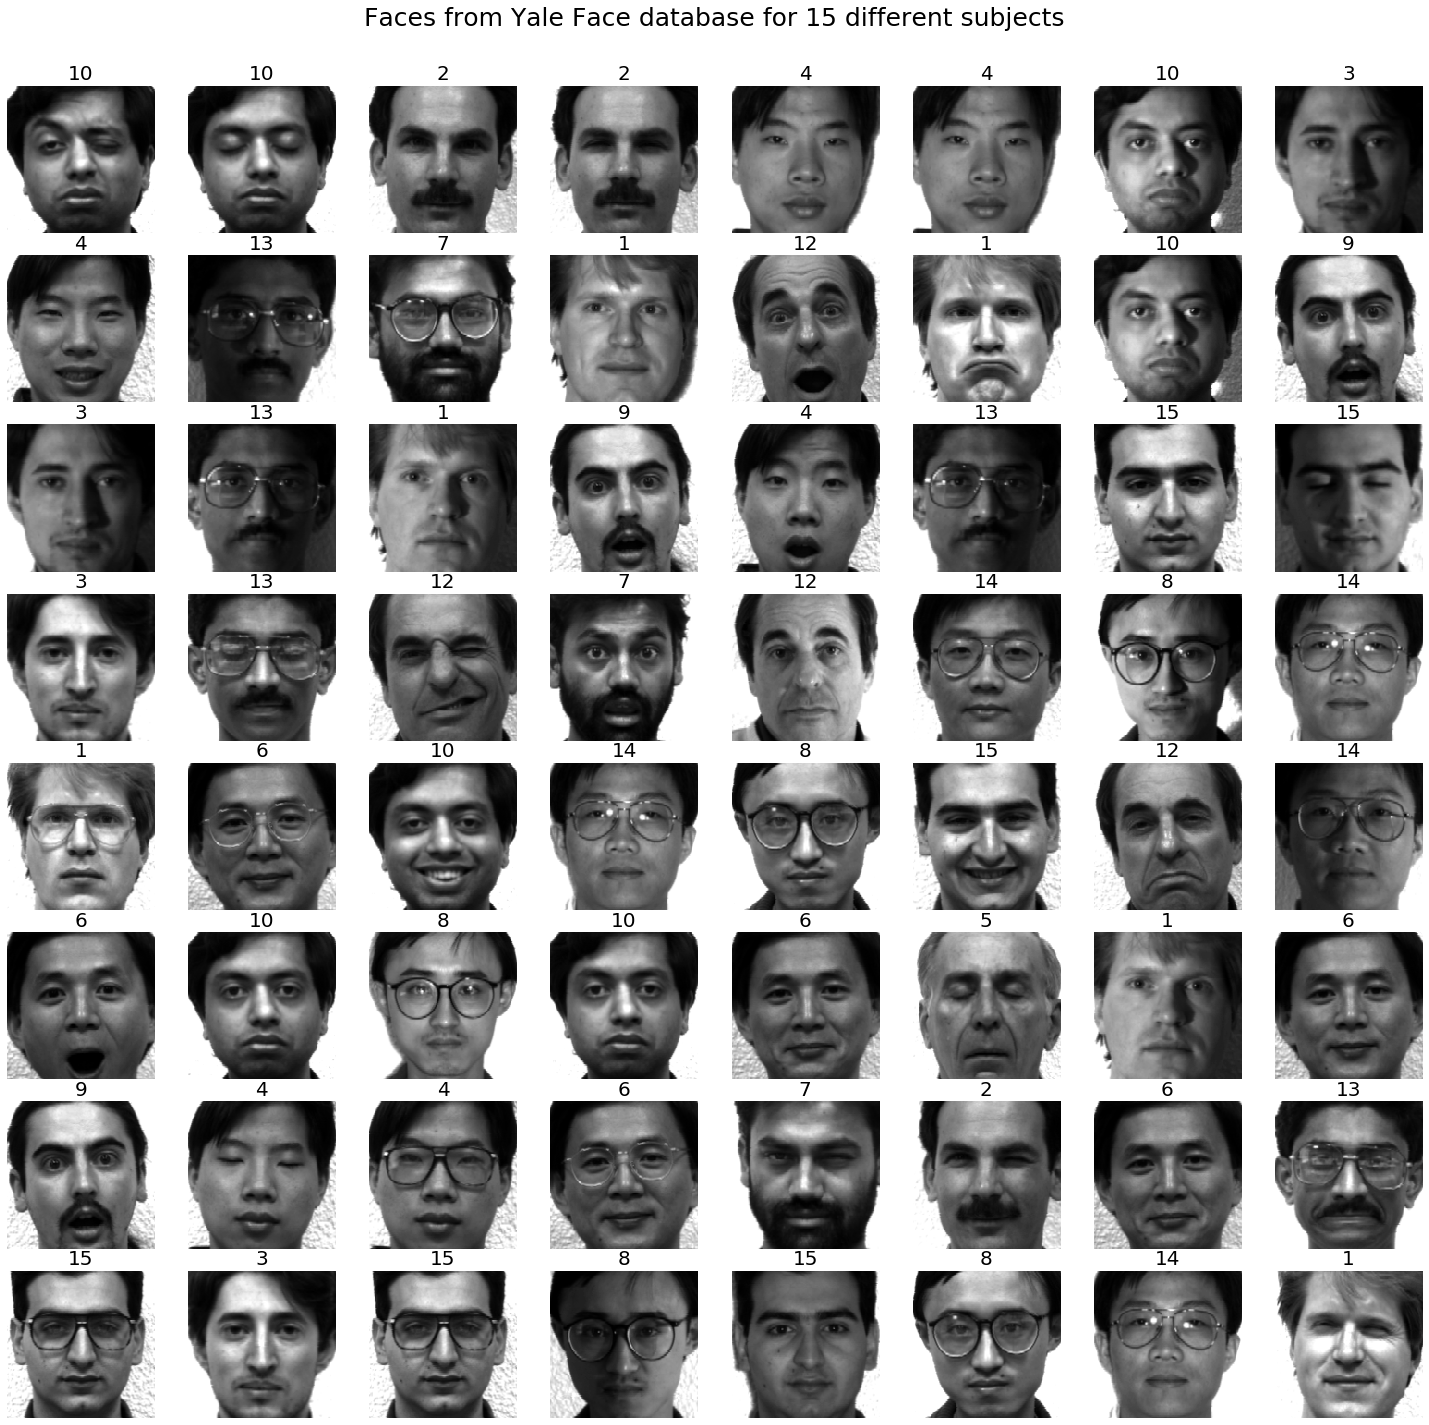

In [10]:
indices = np.random.choice(165, 64)
plt.figure(figsize=(20,20))
plt.gray()
plt.subplots_adjust(0,0,1,0.925,0.05,0.15)
for i in range(len(indices)):
    plt.subplot(8,8,i+1), plt.imshow(np.reshape(images[indices[i],:], (160,160))), plt.axis('off')
    plt.title(labels[indices[i]], size=20)
plt.suptitle('Faces from Yale Face database for 15 different subjects', size=25)
plt.show()

In [16]:
def compute_fisherfaces(X_train, X_test, y_train, y_test):

    stamp = time.time()
    
    print('Fitting data into LDA..')
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    print(lda.explained_variance_ratio_)
    
    meanfaces, classes = lda.means_, lda.classes_
    plt.figure(figsize=(20,12))
    for i in range(15):
        plt.subplot(3,5,i+1), plt.imshow(np.reshape(meanfaces[i], (160,160))), plt.axis('off')
        plt.title(classes[i], size=20)
    plt.suptitle('FisherFaces for the subjects', size=25)
    plt.show()
    
    X_train = lda.transform(X_train)
    X_test = lda.transform(X_test)

    print('Data fitting into LDA finished.')
    print('Training process finished in ' + str(round((time.time() - stamp), 5))+' seconds.')
    
    cls = KNeighborsClassifier(n_neighbors=5)
    cls.fit(X_train, y_train)
    prediction = cls.predict(X_test)
    print('Data prediction finished.')
    print('Classification report\n'+classification_report(
        y_test, prediction, labels=np.unique(prediction)
    ))
    print(accuracy_score(y_test, prediction)) 

In [17]:
scaler = StandardScaler()
images = scaler.fit_transform(images)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, stratify=labels, random_state=42)

Fitting data into LDA..
[0.234745   0.17225883 0.12595579 0.08408923 0.06826283 0.05255275
 0.05051213 0.04835622 0.04042571 0.03456516 0.03072084 0.0218708
 0.01971916 0.01596556]


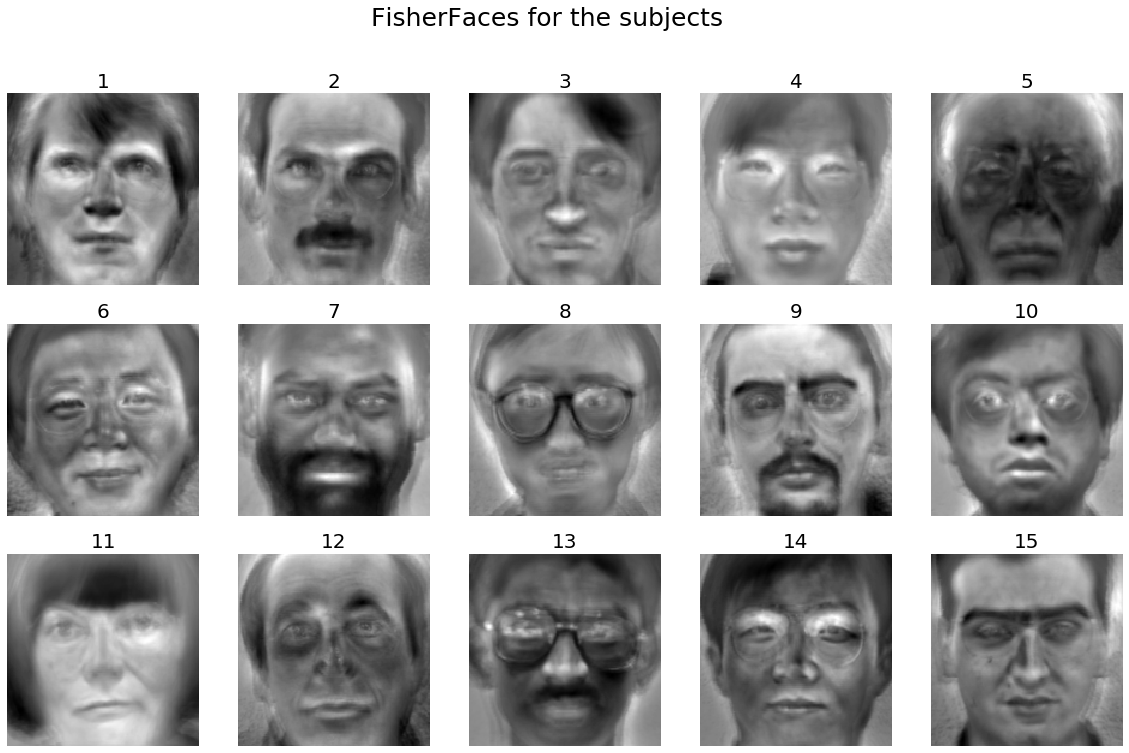

Data fitting into LDA finished.
Training process finished in 1.90104 seconds.
Data prediction finished.
Classification report
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           3       0.50      1.00      0.67         1
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1

   micro avg       0.88      0.94      0.91        16
   macro

In [18]:
compute_fisherfaces(X_train, X_test, y_train, y_test)

### Face Recognition with Local Binary Patterns Histogram (LBPH) with *opencv-python*

In [68]:
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train([np.reshape(im, (160,160)) for im in X_train.tolist()], np.array(y_train))
correct = 0
for i in range(len(y_test)):
    nbr_predicted, conf = recognizer.predict(np.reshape(X_test[i,:], (160,160)))
    nbr_actual = y_test[i]
    if nbr_actual == nbr_predicted:
        print("{} is Correctly Recognized with confidence {}".format(nbr_actual, conf))
        correct += 1
    else:
        print("{} is Incorrectly Recognized as {}".format(nbr_actual, nbr_predicted))
print('test accuracy = {}'.format(correct/len(y_test)))

7 is Correctly Recognized with confidence 60.060702131229704
4 is Incorrectly Recognized as 10
4 is Correctly Recognized with confidence 38.001703557304054
1 is Correctly Recognized with confidence 42.21533783221222
2 is Correctly Recognized with confidence 0.0
11 is Correctly Recognized with confidence 38.41255543915694
7 is Correctly Recognized with confidence 43.037801642508036
8 is Correctly Recognized with confidence 50.94998833513459
13 is Incorrectly Recognized as 7
14 is Incorrectly Recognized as 6
15 is Correctly Recognized with confidence 47.2086287559861
12 is Correctly Recognized with confidence 55.50225332164219
6 is Incorrectly Recognized as 14
5 is Correctly Recognized with confidence 26.645841231474027
3 is Correctly Recognized with confidence 51.78069654912484
9 is Incorrectly Recognized as 2
10 is Correctly Recognized with confidence 38.970157602508884
test accuracy = 0.7058823529411765


## 6. Face Detection and Recognition with Microsoft Cognitive Vision APIs

In [69]:
# https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts/python-disk

import os
import sys
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from skimage.color import gray2rgb

In [70]:
subscription_key ='<your key here>' # must use your key here, otherwise you will not be able to use the service
endpoint = 'https://xxxxxxxxxxxxx.api.cognitive.microsoft.com' # replace this by your endpoint

In [ ]:
analyze_url = endpoint + "/vision/v3.0/analyze"

In [ ]:
def detect_face_age_geneder(img):
    
    # Read the image into a byte array
    image_data = open(img, "rb").read()
    
    headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
    params = {'visualFeatures': 'Faces', "details": "", "language": "en"}
    response = requests.post(analyze_url, headers=headers, params=params, data=image_data)
    response.raise_for_status()
    out = response.json()
    print(out)
    
    image = Image.open(BytesIO(image_data))
    image = gray2rgb(np.array(image))
    for face in out['faces']:
        age = face["age"]
        gender = face["gender"]
        box = face["faceRectangle"]
        x1, y1, x2, y2 = int(box['left']), int(box['top']), int(box['left'] + box['height']), int(box['top'] + box['width'])
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2) 
        image = cv2.putText(image, 'age={}'.format(age), (x1, y1-5), \
                                cv2.FONT_HERSHEY_SIMPLEX ,  1, (255,0,0), 2, cv2.LINE_AA) 
        image = cv2.putText(image, gender, (x1, y2+25), \
                                cv2.FONT_HERSHEY_SIMPLEX ,  1, (255,0,0), 2, cv2.LINE_AA) 

    # Display the image and overlay it with the caption.
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis("off")
    plt.title('Face Recognition with Microsoft Cognitive Vision API', size=20)
    plt.show()

{'faces': [{'age': 27, 'gender': 'Female', 'faceRectangle': {'left': 67, 'top': 31, 'width': 134, 'height': 141}}], 'requestId': 'd8ca1cfc-88d6-49be-979b-30275d657bfb', 'metadata': {'width': 202, 'height': 277, 'format': 'Jpeg'}}


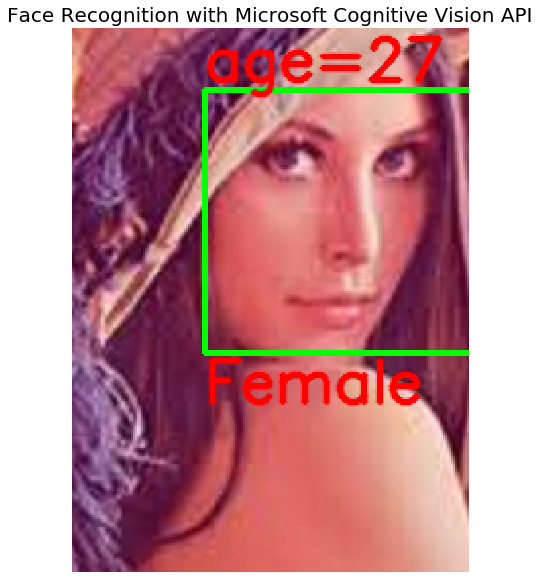

In [68]:
detect_face_age_geneder('images/Img_04_02.jpg')

In [ ]:
analyze_url = endpoint + "/vision/v3.0/models/celebrities/analyze"

In [ ]:
def recognize_celeb_face(img):
    
    # Read the image into a byte array
    image_data = open(img, "rb").read()
    image = Image.open(BytesIO(image_data))
    headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'}
    params = {'visualFeatures': 'Categories,Description,Color', "details": "", "language": "en"}
    response = requests.post(analyze_url, headers=headers, params=params, data=image_data)
    response.raise_for_status()
    out = response.json()
    print(out)
    
    image = gray2rgb(np.array(image))
    for celeb in out['result']["celebrities"]:
        name = celeb["name"].capitalize()
        confidence = celeb["confidence"]
        box = celeb["faceRectangle"]
        x1, y1, x2, y2 = int(box['left']), int(box['top']), int(box['left'] + box['height']), int(box['top'] + box['width'])
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 2) 
        image = cv2.putText(image, name, (x1-5, y1-5), \
                                cv2.FONT_HERSHEY_SIMPLEX ,  1, (255,0,0), 2, cv2.LINE_AA) 
        image = cv2.putText(image, 'conf={:.03f}'.format(confidence), (x1, y2+25), \
                                cv2.FONT_HERSHEY_SIMPLEX ,  1, (255,0,0), 2, cv2.LINE_AA) 

    # Display the image and overlay it with the caption.
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis("off")
    plt.title('Face Recognition with Microsoft Cognitive Vision API', size=20)
    plt.show()

{'result': {'celebrities': [{'faceRectangle': {'top': 96, 'left': 415, 'width': 87, 'height': 87}, 'name': 'Albert Einstein', 'confidence': 0.9985173344612122}, {'faceRectangle': {'top': 58, 'left': 83, 'width': 85, 'height': 85}, 'name': 'Rabindranath Tagore', 'confidence': 0.9770157933235168}]}, 'requestId': '6c078547-4da7-4f37-9d4b-ccfb1d20a52b', 'metadata': {'width': 654, 'height': 500, 'format': 'Jpeg'}}


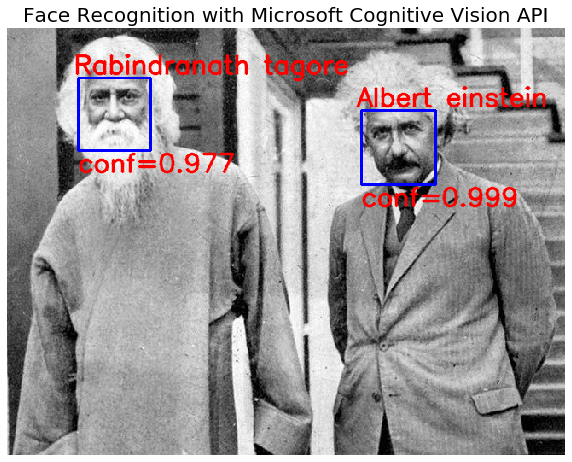

In [59]:
recognize_celeb_face("images/Img_07_20.jpg")

![](images/Img_07_21.png)